# Evalution and Analysis

## Imports:

In [21]:
from pathlib import Path
from Helper.evaluation_helpers import get_predictions, calc_metrics, error_plot,plot_metric
import warnings
from matplotlib import pyplot as plt

### Supress warnings

In [22]:
warnings.filterwarnings("ignore") 

In [23]:
import numpy as np
from pathlib import Path

predsPath = Path('../Predictions/')
for i in list(predsPath.glob('*.npy')):
    data = np.load(i)
    print(f" {i.name} has {len(data)} values")  # Show length of each prediction file


 VAR_cointegration.npy has 12 values
 Tide.npy has 12 values
 LSTM.npy has 12 values
 XGB.npy has 48 values
 ARDL.npy has 12 values
 GRU.npy has 900 values
 NHITS.npy has 12 values
 Naive.npy has 48 values
 Random_Forest_X.npy has 12 values
 VAR_ccf.npy has 12 values
 NBEATSx.npy has 12 values
 RNN.npy has 900 values
 MLR.npy has 48 values


In [24]:
# metric DataFrames are sorted by the main metric before being displayed
main_metric = 'RMSE'

# Horizon = 1:

,RMSE,MAE,r2
ARIMAX1990,0.261509,0.215859,0.873131
SARIMAX1990,0.269689,0.25457,0.865069
ARIMA1990,0.278222,0.22374,0.856396
Naive,0.292784,0.26025,0.84097
SARIMA1990,0.33694,0.285122,0.789385
VARcointegration,0.558785,0.505504,0.420741
VARccf,0.626305,0.611547,0.272295
LSTM,1.602009,1.278878,-3.761173
ARDL,2.640828,2.610789,-11.937913
TFT,2.680355,2.576154,-12.32812


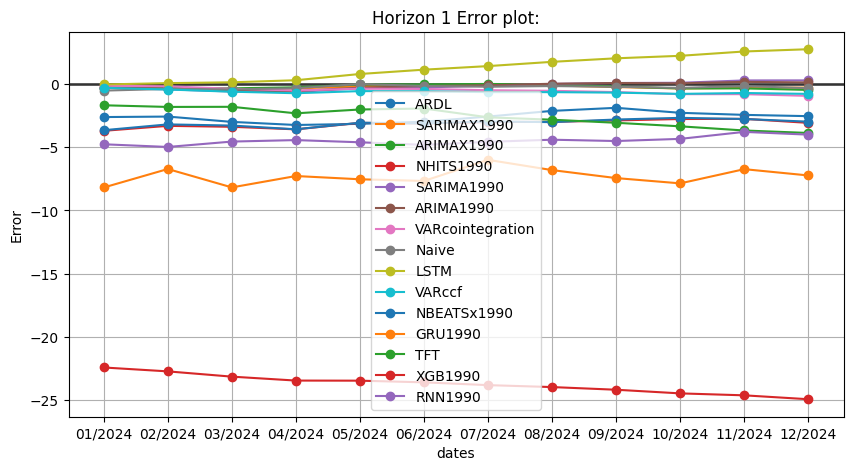

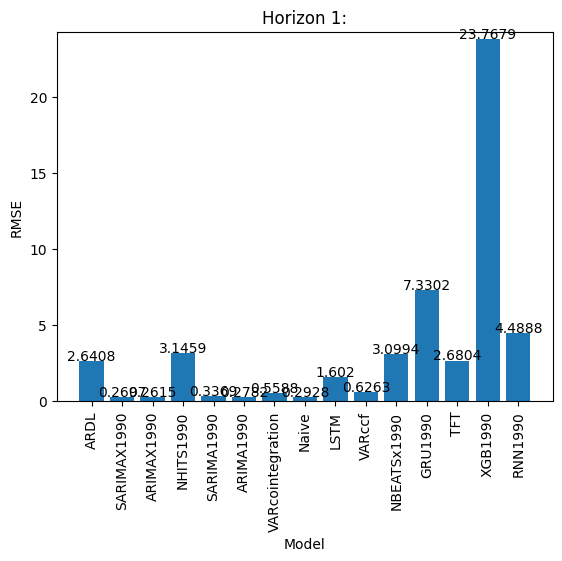

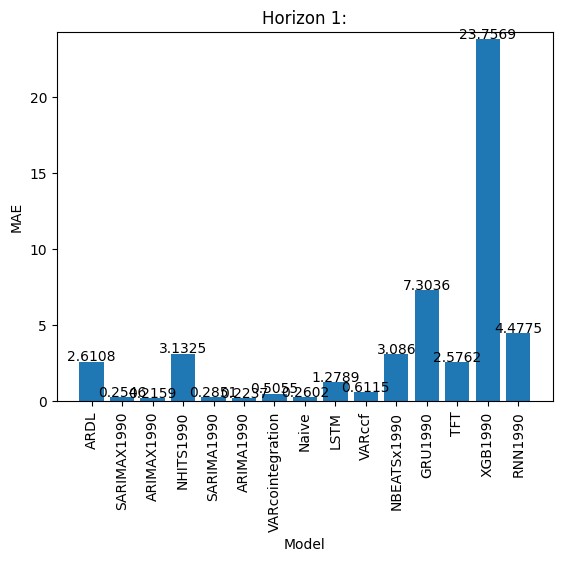

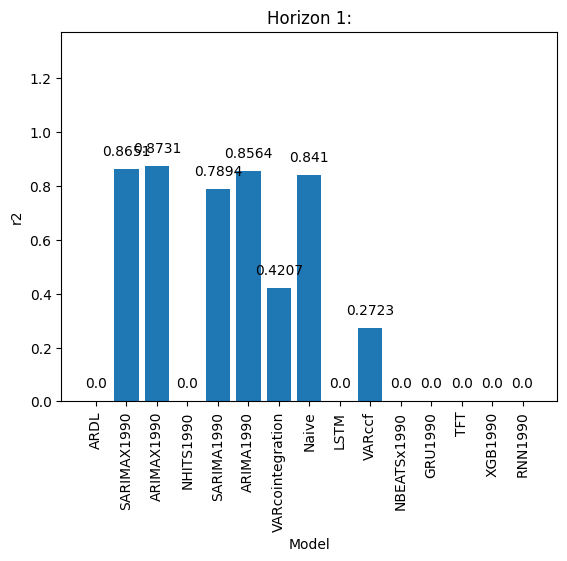

In [25]:
predsPath_1= Path('../Predictions/Horizon1')
predsDf_1=get_predictions(predsPath_1)

metrics_1= calc_metrics(predsDf_1)
display(metrics_1.sort_values(main_metric, axis=0))

error_plot(predsDf_1,model='all',absolute=False, title= 'Horizon 1 Error plot:')

for i in metrics_1.columns:
    plot_metric(metrics_1,i,model='all', title='Horizon 1:')

# Horizon = 3:

,RMSE,MAE,r2
Naive,0.616129,0.5375,0.295748
VARccf,0.835942,0.798191,-0.296393
VARcointegration,0.939982,0.879776,-0.639167
LSTM,0.960128,0.758273,-0.710182
TFT,2.067248,1.758727,-6.928104
ARDL,2.537766,2.492736,-10.947779
NBEATSx1990,3.24316,3.212337,-18.512858
NHITS1990,3.245888,3.214122,-18.545702
GRU1990,7.344475,7.324929,-99.070388
RNN1990,7.866641,7.860677,-113.805507


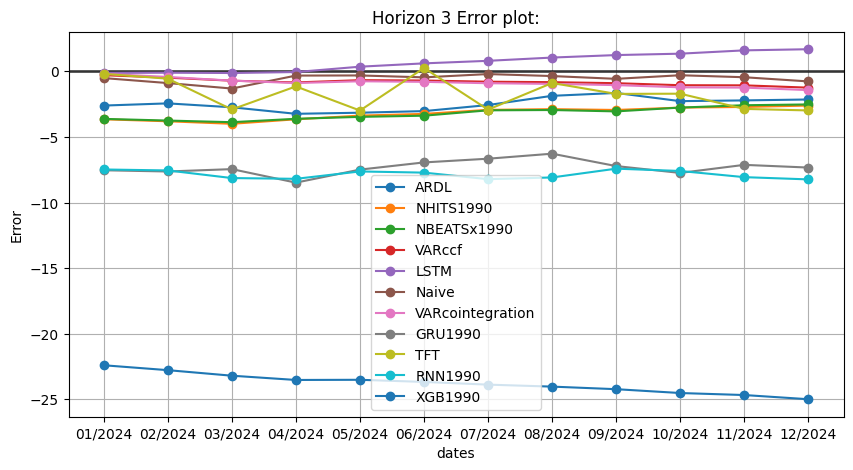

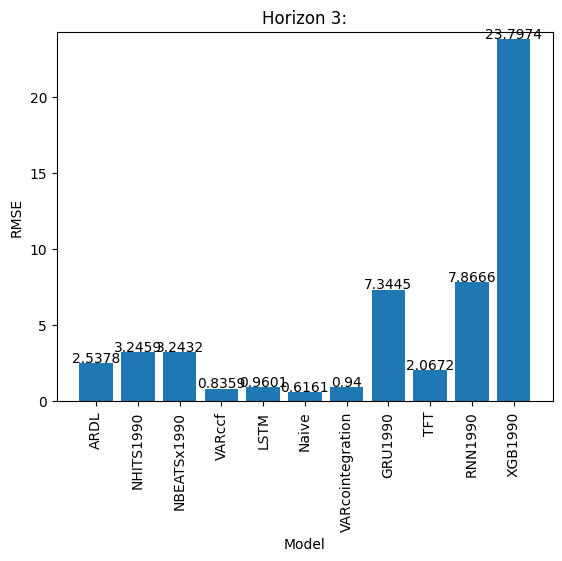

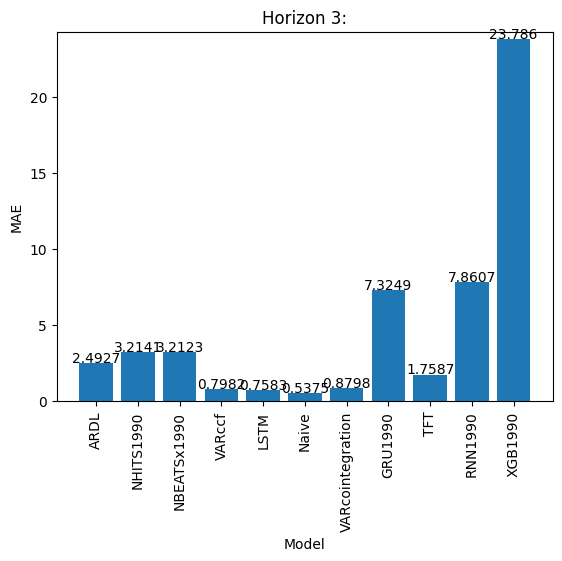

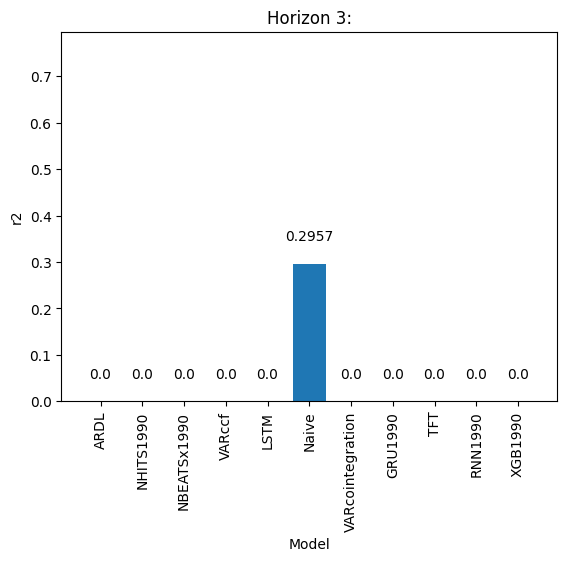

In [26]:
predsPath_3= Path('../Predictions/Horizon3')
predsDf_3=get_predictions(predsPath_3)

metrics_3= calc_metrics(predsDf_3)
display(metrics_3.sort_values(main_metric, axis=0))

error_plot(predsDf_3,model='all',absolute=False, title= 'Horizon 3 Error plot:')
for i in metrics_3.columns:
    plot_metric(metrics_3,i, title='Horizon 3:')

# Horizon = 6:

,RMSE,MAE,r2
Naive,1.127616,1.0075,-1.358883
VARccf,1.17718,1.109972,-1.570811
VARcointegration,1.21846,1.12629,-1.754269
ARDL,2.271809,2.233214,-8.574754
NHITS1990,3.326016,3.300174,-19.522616
NBEATSx1990,3.476542,3.450648,-21.422246
TFT,4.017051,3.970676,-28.93634
GRU1990,4.272294,3.82898,-32.861521
LSTM,5.346032,4.639163,-52.02092
RNN1990,8.525767,8.523391,-133.850032


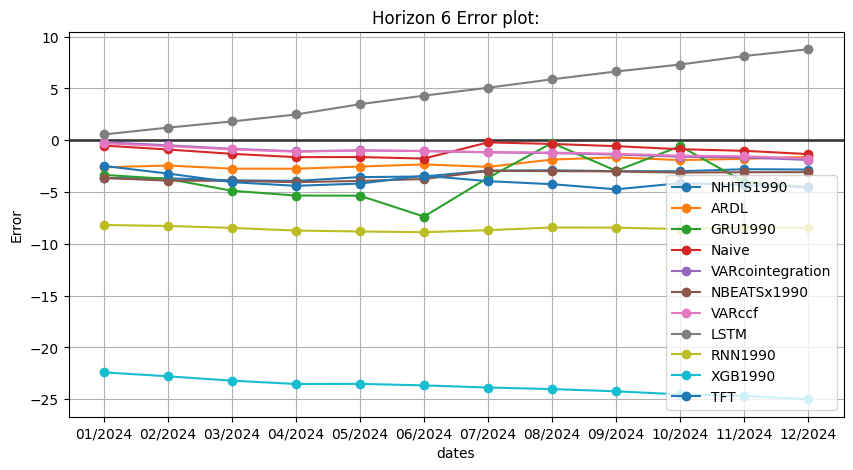

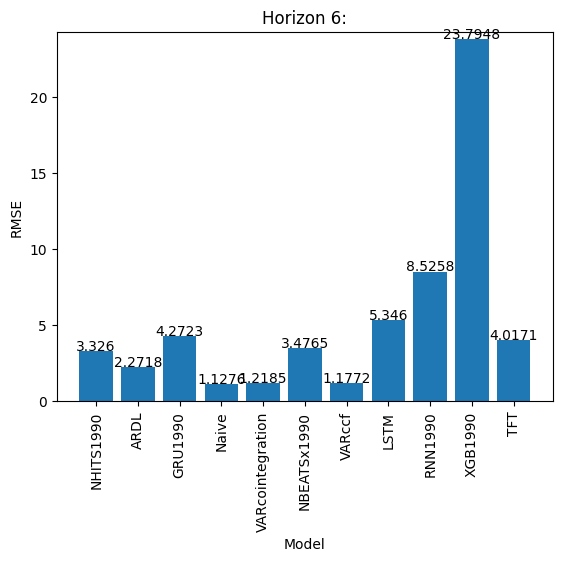

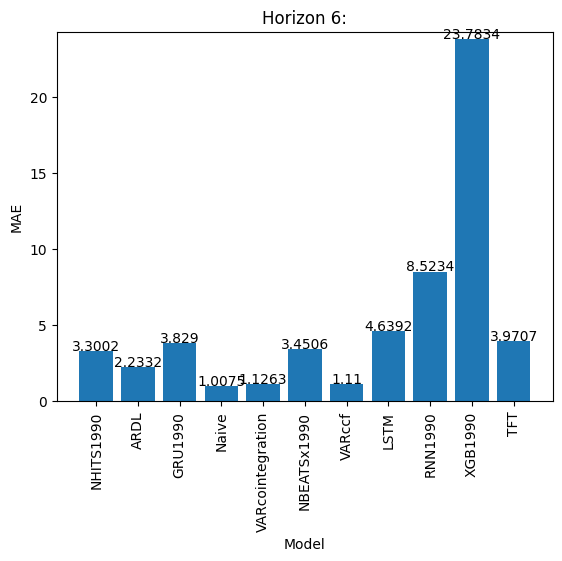

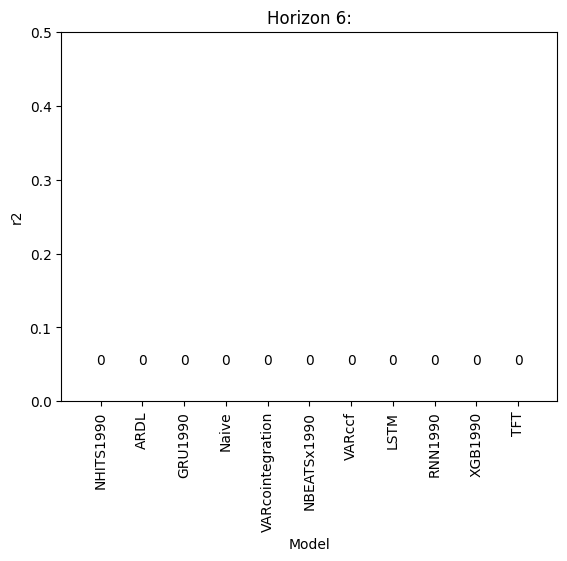

In [27]:
predsPath_6= Path('../Predictions/Horizon6')
predsDf_6=get_predictions(predsPath_6)

metrics_6= calc_metrics(predsDf_6)
display(metrics_6.sort_values(main_metric, axis=0))

error_plot(predsDf_6,model='all',absolute=False, title= 'Horizon 6 Error plot:')
for i in metrics_6.columns:
    plot_metric(metrics_6,i, title='Horizon 6:')

# Horizon = 12:

,RMSE,MAE,r2
VARcointegration,1.780569,1.622156,-4.881682
VARccf,1.785207,1.627247,-4.912367
Naive,2.028525,1.891,-6.633873
ARDL,2.108911,2.017296,-7.250887
NHITS1990,3.817656,3.814612,-26.038188
NBEATSx1990,4.143827,4.138137,-30.855714
TFT,4.180308,3.922822,-31.419083
RNN1990,12.668438,12.660472,-296.735249
GRU1990,12.949819,12.847308,-310.108247
LSTM,15.231358,13.187456,-429.389224


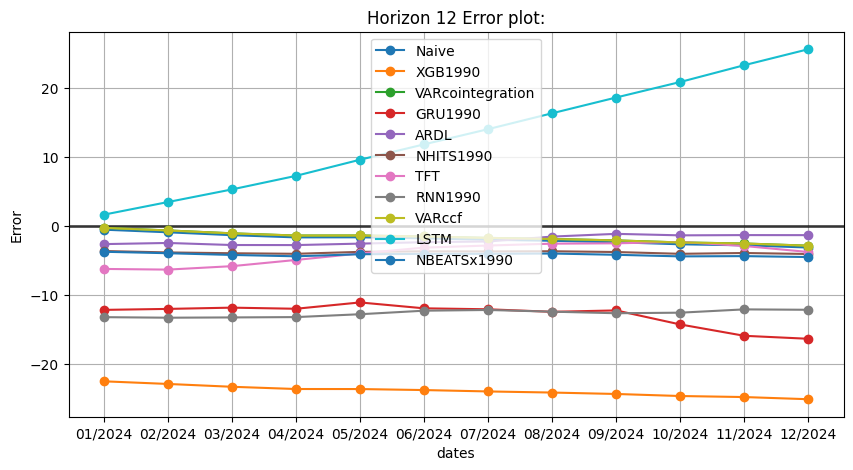

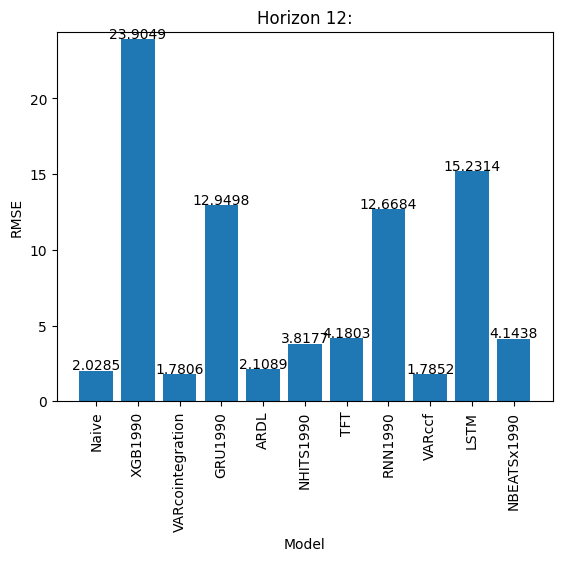

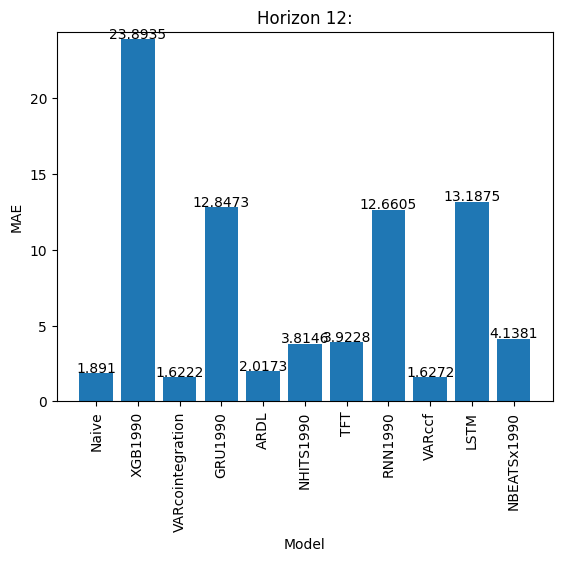

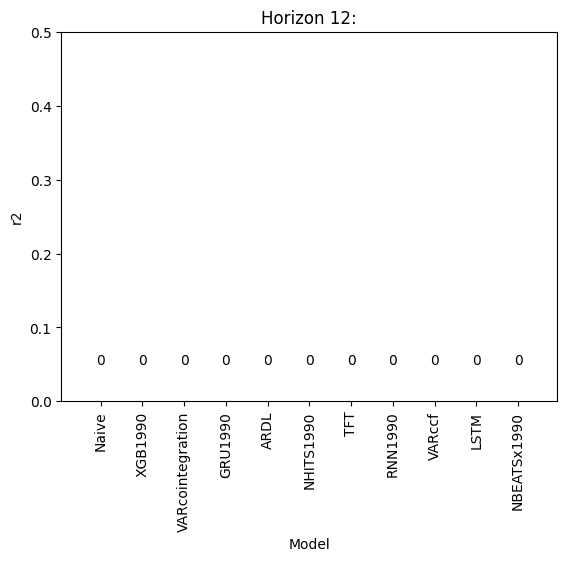

In [28]:
predsPath_12= Path('../Predictions/Horizon12')
predsDf_12=get_predictions(predsPath_12)

metrics_12= calc_metrics(predsDf_12)
display(metrics_12.sort_values(main_metric, axis=0))

error_plot(predsDf_12,model='all',absolute=False, title= 'Horizon 12 Error plot:')
for i in metrics_12.columns:
    plot_metric(metrics_12,i, title='Horizon 12:')